#### 1. [Installation and Importing of Libraries](#eda_import)
#### 2. [Retreival of Data and Cleanup](#eda_retrieval)
#### 3. [Handling of NAs](#eda_na)
#### 4. [Feature Reduction](#reduction)
#### 5. [Visualization](#visualization)

This was a workbook that first started as a cleanup of our merged dataset that also began some of our modeling efforts.  It's been revised to now use our cleaned "merged_df" data.  We still use Random Forest to look at Feature Importance however the findings are consistent with what's expected - a stronger correlation to Bone Mineral Density.  Some of the other features could be interesting when cross-referenced with what we find from our other techniques. 

### <a name="eda_import"></a>Installation and Importing of Libraries
In order to both explore and visualize the data, it's necessary for us to load various libraries.  In addition to loading already pre-installed libraries, we've also had to install seaborn for plotting. 

In [2]:
!pip install seaborn --upgrade

Requirement already up-to-date: seaborn in /opt/conda/lib/python3.7/site-packages (0.12.2)


In [3]:
##import libraries required for analysis
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import mpl_toolkits.mplot3d
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import psycopg2
import sqlalchemy
import getpass
import pandas as pd 


### <a name="eda_retrieval"></a>Retreival of Data and Cleanup
We need to retrieve all the CSVs that have been cleaned by our team and then merge them together based on the ID field.  There's also some minor carpentry work we need to do before running any models

In [4]:
# Hooray for clean data!  No  need to do this anymore.  
# dir_path = '/dsa/groups/casestudy2023su/team03/model_data/'

# # Get all files in the directory and filter CSVs
# file_names = os.listdir(dir_path)
# csv_files = [file for file in file_names if file.endswith('.csv')]
# dfs = []

# # Loop all csv files and read 
# for csv_file in csv_files:
#     df = pd.read_csv(os.path.join(dir_path, csv_file))
    
#     #some files have id in lowercase and others in uppercase
#     if 'Id' in df.columns:
#         df = df.rename(columns={'Id': 'ID'})
#     elif 'id' in df.columns:
#         df = df.rename(columns={'id': 'ID'})
    
#     dfs.append(df)

#     # Print name and columns
#     print(f"File: {csv_file}")
#     print("Columns:", df.columns)
#     print()

# # Merge all dataframes on 'ID'
# merged_df = dfs[0]
# for df in dfs[1:]:
#     merged_df = pd.merge(merged_df, df, on='ID', how='outer')

# # Converting everything to uppercase for simplicity
# merged_df.columns = merged_df.columns.str.upper()

# # Update "yes" values to 1 and "no" values to 0
# for column in merged_df.columns:
#     if merged_df[column].dtype == object:
#         merged_df[column] = merged_df[column].replace({'yes': 1, 'no': 0, '0': 0})

# print(merged_df)

# Set file path
file_path = "/dsa/groups/casestudy2023su/team03/merged_data/mros_merged_clean.csv"

# Load dataframe from CSV
merged_df = pd.read_csv(file_path)

In [5]:
merged_df.describe()

,B1TRD,B1ITD,B1FND,B1L1D,B1L3D,B1TBD,B1HDD,B1LAD,B1RAD,B1LRD,...,RADIALPULSE_MEAS1,BMI,HEIGHTCHANGEFROM25,WEIGHTCHANGEFROM25,FAFXN,FAFXNT,GIAGE1,FAFXN_BIN,FAFXNT_BIN,outlier
count,5994.000000,5994.000000,5994.000000,5994.000000,5994.000000,5994.000000,5994.000000,5994.000000,5994.000000,5994.000000,...,5994.000000,5994.000000,5994.000000,5994.000000,5994.000000,5994.000000,5994.000000,5994.000000,5994.000000,5994.000000
mean,0.764990,1.111712,0.784170,0.979764,1.098752,1.167219,2.132447,0.848691,0.861511,0.706571,...,64.349891,27.378324,3.705292,10.339891,0.432432,0.343577,73.657658,0.253420,0.214715,0.899900
std,0.127367,0.166538,0.128116,0.176903,0.207320,0.126578,0.332499,0.091894,0.092162,0.135757,...,9.989382,3.829940,2.960090,11.375341,1.002012,0.813297,5.872264,0.435006,0.410659,0.436133
min,0.167047,0.389357,0.272729,0.298691,0.382238,0.764788,1.056920,0.515547,0.515601,0.443625,...,36.000000,17.211000,-30.180000,-42.393700,0.000000,0.000000,64.000000,0.000000,0.000000,-1.000000
25%,0.677239,0.998989,0.696196,0.859821,0.955975,1.083122,1.905628,0.791598,0.804045,0.636937,...,58.000000,24.777850,1.970000,2.994512,0.000000,0.000000,69.000000,0.000000,0.000000,1.000000
50%,0.758539,1.104805,0.773544,0.968030,1.081870,1.157550,2.113950,0.843987,0.856622,0.691454,...,64.000000,26.905750,3.590000,9.365350,0.000000,0.000000,73.000000,0.000000,0.000000,1.000000
75%,0.847302,1.221518,0.860129,1.086195,1.219765,1.241125,2.339317,0.898742,0.913262,0.751444,...,70.000000,29.490625,5.240000,17.125600,1.000000,0.000000,78.000000,1.000000,0.000000,1.000000
max,1.699030,1.984450,1.598350,1.976850,2.245680,2.046580,4.695200,1.945820,2.139360,4.667740,...,198.000000,50.668700,30.870000,69.257700,12.000000,12.000000,100.000000,1.000000,1.000000,1.000000


### <a name="eda_na"></a>Handling of NAs

In [6]:
# Clean data - no need for this anymore!
pd.set_option('display.max_rows', None)
missing_values = merged_df.isna().sum()
missing_values = missing_values[missing_values > 0]
print(pd.DataFrame(missing_values, columns=['Missing Values']))
pd.reset_option('display.max_rows')

Empty DataFrame
Columns: [Missing Values]
Index: []


### <a name="cleanup"></a> Data Cleanup
In order to do my feature reduction, we're going to need to perform just tiny bit of carpentry.  First, let's look at what non-numeric values we have and then and then determine whether one-hot encoding is necessary.

In [7]:
alphanumeric_features = []

for column in merged_df.columns:
    if merged_df[column].dtype == object:
        alphanumeric_features.append(column)

for feature in alphanumeric_features:
    if feature in merged_df.columns:
        print("Feature:", feature)
        print(merged_df[feature].unique())
        print()
    else:
        print("Feature", feature, "does not exist in the DataFrame.")
        print()

Feature: GIEDUC
['7. Some Grad' '5. Some College' '3. Some Highschool' '4. High School'
 '6. College' '8. Grad School' '2. Elementary' '1. Some Elementary']

Feature: GIERACE
['1. WHITE' '5. OTHER' '2. AFRICAN AMERICAN' '4. HISPANIC' '3. ASIAN']



We'll trim these values to just the very first number.  It'll be important to remember that it's still categorical and not continuous.  

In [8]:
merged_df["GIEDUC"] = merged_df["GIEDUC"].str.extract(r'^(\d+)', expand=False).astype(int)
merged_df["GIERACE"] = merged_df["GIERACE"].str.extract(r'^(\d+)', expand=False).astype(int)

In [9]:
# No longer need to delete these columns
#merged_df = merged_df.drop(['ID', 'STAFFID#', 'NPSTAFF'], axis=1)

## <a name="reduction"></a> Feature Reduction

### Removal of Highly Correlated Features

This logic is now being done upstream and no longer necessary.

In [10]:
# Count the number of columns that are not independent variables
independent_vars = ['FAFXN', 'FAFXNT', 'FAFXN_BIN', 'FAFXNT_BIN']
num_columns = sum(1 for col in merged_df.columns if col not in independent_vars)

print("Number of columns (excluding independent variables):", num_columns)

Number of columns (excluding independent variables): 267


### Recursive Feature Elimintation

Since the number of columns still remaining is still higher than we want to work with, we'll use now Recursive Feature Elimination by training a Random Forest model and removing the least important feature at each iteration.

In [12]:
# Perform Recursive Feature Elimination with Rand Forest Classifier
# Starting with just traumatic fractures (FAFXN)
# Adding the class_weight parameter
model = RandomForestClassifier(n_estimators=100, class_weight='balanced')
rfe = RFE(estimator=model, n_features_to_select=25)
X = merged_df.drop(['FAFXN', 'FAFXNT', 'FAFXN_BIN', 'FAFXNT_BIN'], axis=1)  # Exclude target variables
y = merged_df['FAFXN_BIN']  # Target variable
X_selected = rfe.fit_transform(X, y)

# Get selected feature names
selected_feature_names = X.columns[rfe.support_]

# Filter the DataFrame to include only selected features
merged_df = merged_df[selected_feature_names.union(['FAFXN_BIN'])]

## <a name="visualization"></a> Visualization

In [13]:
#creating initial temp split of 10% for testing
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

#second split of 10% for validation... leaving us with 80% for training.
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1111, random_state=42) # 0.1111 * 0.9 = 0.1

# Train the Random Forest Classifier
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.75


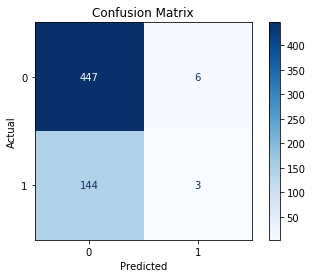

In [14]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)

cm_display.plot(cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

We see that wer'e still getting a high amount of False Negatives (144).  In our scenario, we would prefer to error on the side of caution when it comes to fractures and have a higher number of False Positives (6).  

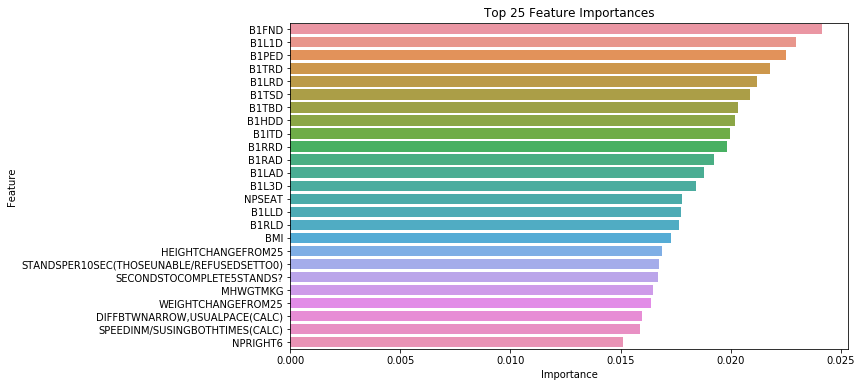

In [15]:
# Get feature importances
feature_importances = model.feature_importances_

# Create a DataFrame to show feature importance
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values('Importance', ascending=False)

# Select top 25 features
top_25_features = importance_df.head(25)

# Plot top 25 feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_25_features)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 25 Feature Importances')
plt.show()

As anticipated, the highest level of correlation comes from Bone Mineral Density (B1 data) but we do also see other interesting findings around weight (weightchangefrom25, BMI). 